In [1]:
%%time
import math
import os
from PIL import Image
from dask.diagnostics import ProgressBar
from imageio import imread
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

Wall time: 958 ms


In [2]:
class KMeansReducedPalette:
    ''' The K-means reduced palette class.

    Takes an image and performs k-means on all the RGB pixels of the image. The
    value of k is equal to `num_colors`.

    Args
    ---
        num_colors (int): the number of colors in the reduced palette.
    '''
    def __init__(self, num_colors):
        self.num_colors = num_colors
        self.kmeans = KMeans(num_colors, random_state=0xfee1600d)
        self.source_pixels = None

    def _preprocess(self, image):
        ''' Preprocess an image.

        Check that an image has exactly 3 color channels (RGB) and that the
        data type is numpy.uint8 (i.e. values between 0 and 255). Then, convert
        the image from W x H x C into WH x C.

        Args
        ---
            image (numpy.ndarray): the image to be preprocessed.

        Returns
        ---
            numpy.ndarray: the flattened image keeping all RGB pixels in the
                columns.
        '''
        assert image.shape[-1] == 3, 'image must have exactly 3 color channels'
        assert image.dtype == 'uint8', 'image must be in np.uint8 type'

        # Flatten pixels, if not already.
        if len(image.shape) > 2:
            return image.reshape(-1, 3)

        return image

    def fit(self, image):
        ''' The fit function for the palette.
        
        PPreprocesses the reference image and perform k-means clustering on the
        pixels. Then, find the distance of each pixel to the nearest centroid.

        Args
        ---
            image (numpy.ndarray): the reference image for this palette.
        '''
        image_cpy = image.copy()
        self.source_pixels = self._preprocess(image_cpy)
        self.kmeans.fit(self.source_pixels)
        
        self.centroid_nearest_pixels = []

        for ci in range(self.num_colors):
            pixels_ci = self.source_pixels[self.kmeans.labels_ == ci]
            distances_ci = np.sqrt(np.sum(np.square(
                pixels_ci - self.kmeans.cluster_centers_[ci]), axis=1))
            pixels_ci = pixels_ci[np.argsort(distances_ci)]

            self.centroid_nearest_pixels.append(pixels_ci)

    def recolor(self, image):
        ''' Transfer the reduced palette onto another image.

        Takes an image, applies k-means clustering on the pixels of the image,
        replace the predicted cluster center's color onto the image.

        Args
        ---
            image (numpy.ndarray): the input image for palette reduction.

        Returns
        ---
            numpy.ndarray: the recolored image based on this reduced palette.
        '''
        original_shape = image.shape
        image = self._preprocess(image)
        recolor_idx = self.kmeans.predict(image)
        recolor = self.kmeans.cluster_centers_[recolor_idx]
        recolor = np.round(recolor).astype(np.uint8)  # Round back to 0-255.

        return recolor.reshape(original_shape)
    
    def random_walk_recolor(self, image, max_steps):
        ''' Recolor with a random walk.

        Does recoloring and adds a random value depending on the `max_steps`.
        Any values outside the range of [0, 255] are clipped to keep the image
        "visible".

        Args
        ---
            image (numpy.ndarray): the input image for palette reduction.
            max_steps (int): maximum number of RGB value to move.

        Returns
        ---
            numpy.ndarray: the recolored image with random walk applied.
        '''
        original_shape = image.shape
        image = self._preprocess(image)
        centroid_idxs = self.kmeans.predict(image)
        start = np.round(self.kmeans.cluster_centers_[centroid_idxs])

        diff = np.zeros(image.shape)

        for _ in range(max_steps):
            walk = np.eye(3)[np.random.randint(0, 3, size=image.shape[0])]
            sign = np.random.choice([-1, 1], size=(image.shape[0], 1))
            diff += walk * sign

        recolor = np.clip(start + diff, 0, 255).astype(np.uint8)

        return recolor.reshape(original_shape)
    
    def random_neighborhood_walk_recolor(self, image, max_steps):
        ''' Recolor with a random walk.

        Does recoloring and adds randomly jumps to the closests neighbors. The
        maximum number of jumps is given by `max_steps`.

        Args
        ---
            image (numpy.ndarray): the input image for palette reduction.
            max_steps (int): maximum number of RGB value to move.

        Returns
        ---
            numpy.ndarray: the recolored image with random neighborhood walk
                applied.
        '''
        original_shape = image.shape
        image = self._preprocess(image)
        recolor = image.copy()
        centroid_idxs = self.kmeans.predict(image)

        for ci in range(self.num_colors):
            n_pixels = np.sum(centroid_idxs == ci)

            if n_pixels == 0:
                continue

            n_neighbors = self.centroid_nearest_pixels[ci].shape[0]
            # Don't jump to a neighbor further than the furthest neighbor.
            neighbor_idxs = np.random.randint(min(max_steps, n_neighbors),
                                              size=(n_pixels))
            recolor_ci = self.centroid_nearest_pixels[ci][neighbor_idxs]
            recolor[centroid_idxs == ci] = recolor_ci
        
        return recolor.reshape(original_shape)


class UniqueKMeansReducedPalette(KMeansReducedPalette):
    ''' The K-means reduced palette class.

    Takes an image and performs k-means on the _unique_ RGB pixels of the
    image. The value of k is equal to `num_colors`.

    Args
    ---
        num_colors (int): the number of colors in the reduced palette.
    '''
    def __init__(self, num_colors):
        super().__init__(num_colors)

    def fit(self, image):
        ''' The fit function for the palette.
        
        Preprocesses the reference image, get the unique pixels in the image
        and call the fit function of the KMeansReducedPalette class.

        Args
        ---
            image (numpy.ndarray): the reference image for this palette.
        '''
        image_cpy = image.copy()
        pixels = self._preprocess(image_cpy)
        super().fit(np.unique(pixels, axis=0))


class EntirePalette():
    ''' Whole palette transferrer.

    Takes an image and store all the unique pixels and can perform transferring
    all the closests pixels between two images.

    Args
    ---
        chunk_size (int): number of chunks to divide an array into during
            computation.
    '''
    def __init__(self, chunk_size=1024):
        self.chunk_size = chunk_size
        self.source_pixels = None

    def _preprocess(self, image):
        ''' Preprocess an image.

        Check that an image has exactly 3 color channels (RGB) and that the
        data type is numpy.uint8 (i.e. values between 0 and 255). Then, convert
        the image from W x H x C into WH x C.

        Args
        ---
            image (numpy.ndarray): the image to be preprocessed.

        Returns
        ---
            numpy.ndarray: the flattened image keeping all RGB pixels in the
                columns.
        '''
        assert image.shape[-1] == 3, 'image must have exactly 3 color channels'
        assert image.dtype == 'uint8', 'image must be in np.uint8 type'

        # Flatten pixels, if not already.
        if len(image.shape) > 2:
            return image.reshape(-1, 3)

        return image

    def fit(self, image):
        ''' The fit function for the palette.
        
        Preprocesses the reference image, get the unique pixels in the image.

        Args
        ---
            image (numpy.ndarray): the reference image for this palette.
        '''
        self.source_pixels = np.unique(self._preprocess(image), axis=0)

    def recolor(self, image):
        ''' Transfers all colors from the reference image to the input image.

        1) Keep the shape of the input image and preprocess.
        2) Convert the unique pixels array into a dask array and similarly for
            the input image.
        3) Perform the distance calculation between every pair of pixels using
            the color distance.
        4) Map the closest pixels of the reference image to the input image.
        5) Recolor.

        Args
        ---
            image (numpy.ndarray): the input image to be recolored.
        
        Returns
        ---
            numpy.ndarray: the recolored image.
        '''
        image_shape = image.shape
        image = self._preprocess(image)
        image_colors = np.unique(image, axis=0)

        self_da = da.from_array(
            self.source_pixels.astype(np.long), chunks=(self.chunk_size, 3)
        )
        other_da = da.from_array(
            image_colors.reshape(-1, 1, 3).astype(np.long),
            chunks=(self.chunk_size, 1, 3)
        )
        
        rmean_da = (other_da[:, :, 0] + self_da[:, 0]) // 2
        rgb_da = other_da - self_da
        r_da = ((512 + rmean_da) * rgb_da[:, :, 0] ** 2) >> 8
        g_da = 4 * rgb_da[:, :, 1] ** 2
        b_da = ((767 - rmean_da) * rgb_da[:, :, 2] ** 2) >> 8
        result_da = (r_da + g_da + b_da).argmin(axis=1)
        
        with ProgressBar():
            mapping_idx = result_da.compute()
        
        colormap = {tuple(a): tuple(b)
                    for a, b in 
                    zip(image_colors, self.source_pixels[mapping_idx])}
        
        image_recolored = np.array([colormap[tuple(rgb)] for rgb in image])
        return image_recolored.reshape(image_shape).astype(np.uint8)

In [3]:
def closest_rect(n):
    '''Finds the closest height and width of a 2:1 rectangle given the number
    of pixels.

    Args
    ---
        n (int): the number of pixels in an image.
    '''
    k = 0
    while 2 * k ** 2 < n:
        k += 1
    
    return k, 2*k

def visualize_palette(palette, scale=0):
    '''Visualizes a palette as a rectangle of increasingly "bright" colors.

    This method first converts the RGB pixels into grayscale and sorts the
    grayscale pixel intensity as a proxy of sorting the RGB pixels. Then the
    pixels are reshaped into a 2:1 rectangle and displayed. If there are more
    fewer pixels tahn the size of the rectangle, the remaining pixels are given
    a generic gray color.

    Args
    ---
        palette (numpy.ndarray): the RGB pixels of a  color palette.
        scale (int): the scale factor to apply to the image of the palette.
    '''
    palette_gray = palette @ np.array([[0.21, 0.71, 0.07]]).T
    idx = palette_gray.flatten().argsort()
    h, w = closest_rect(palette.shape[0])
    palette_sorted = palette[idx]
    padding = (h*w) - palette.shape[0]
    
    if (h*w) > palette.shape[0]:
        palette_sorted = np.vstack(
            (palette_sorted, 51*np.ones((padding, 3), dtype=np.uint8))
        )

    palette_sorted = palette_sorted.reshape(h, w, 3)
    im = Image.fromarray(palette_sorted)
    
    if scale > 0:
        return im.resize((scale*im.width, scale*im.height), Image.NEAREST)

    return im

In [55]:
def img_resize(image, n=720):
    '''Rescale image to default size of n=720
    
    Maintains the aspect ratio rescales the longer side to required n
    
    Args
    ---
        image (Image.fromarray): RGB image from numpy array with PIL Image.fromarray()
        n (int): required size of image, default is 720 px
    '''
    if image.width > n or image.height > 1028:
        if image.height > image.width:
            factor = n / image.height
        else:
            factor = n / image.width
        tn_image = image.resize((int(image.width * factor), int(image.height * factor)))
        return tn_image

- - - 
# Obtain color-palette using clustering with k-means algorithm
    - unsupervised machine learning
    - to find color palete of k-colors from all pixexel or reduced num of pixels
    - vypocet transfer palety pouze v RGB barevnem prostoru
## Vstupní image
pro výpočet barevné palety

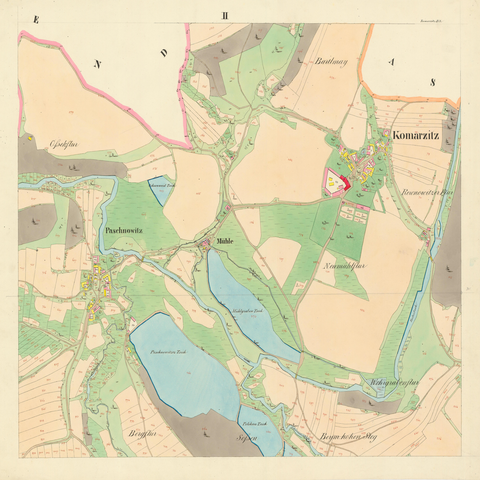

In [17]:
source_image_path = r"d:\_CO\color_balancing\samples\3302-1-002.jpg"  #@param {type: "string"}

src = np.array(imread(source_image_path))[:, :, :3]
src_img = Image.fromarray(src)
display(src_img.resize(maxsize, Image.LANCZOS))

- - - 
## Výstupní image
na který bude aplikována vypočtená barevná paleta

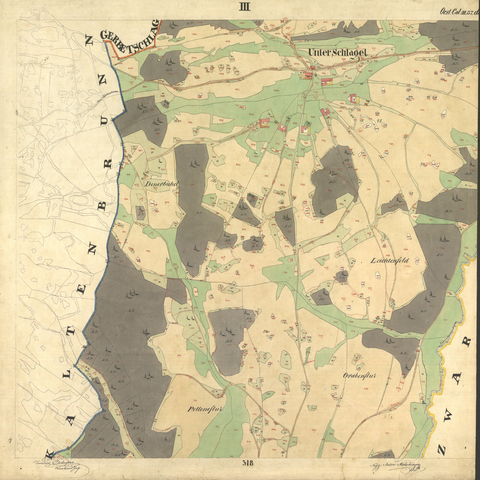

In [21]:
#@markdown Configure the target image.

target_image_path = r"d:\_CO\color_balancing\samples\1273-1-003.jpg"  #@param {type: "string"}

tgt = np.array(imread(target_image_path))[:, :, :3]
tgt_img = Image.fromarray(tgt)
display(tgt_img.resize(maxsize, Image.LANCZOS))

- - - 
## Full redukovaná paleta:
pro k_colors for number of k-mean clusters

Wall time: 31min 55s


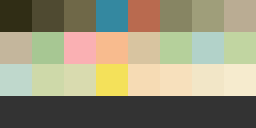

In [24]:
%%time
#@markdown _More colors in the reduced palette results in longer fitting time._
#@markdown Configure the number of colors in the reduced palette.\

k_colors = 24  #@param {type: "slider", min: 2, max: 128, step: 1}

palette_a = KMeansReducedPalette(k_colors)
palette_a.fit(src)
visualize_palette(np.round(palette_a.kmeans.cluster_centers_).astype(np.uint8), scale=32)

In [69]:
np.round(palette_a.kmeans.cluster_centers_).astype(np.uint8)

array([[167, 199, 147],
       [247, 224, 188],
       [135, 133,  99],
       [206, 217, 169],
       [246, 235, 206],
       [ 48,  45,  21],
       [178, 210, 201],
       [196, 182, 156],
       [111, 104,  72],
       [248, 187, 142],
       [186, 172, 147],
       [193, 213, 161],
       [250, 176, 179],
       [ 52, 136, 160],
       [159, 158, 122],
       [216, 196, 160],
       [217, 219, 175],
       [244, 225,  90],
       [ 79,  74,  49],
       [242, 230, 199],
       [246, 219, 180],
       [185, 106,  79],
       [191, 216, 204],
       [181, 208, 155]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

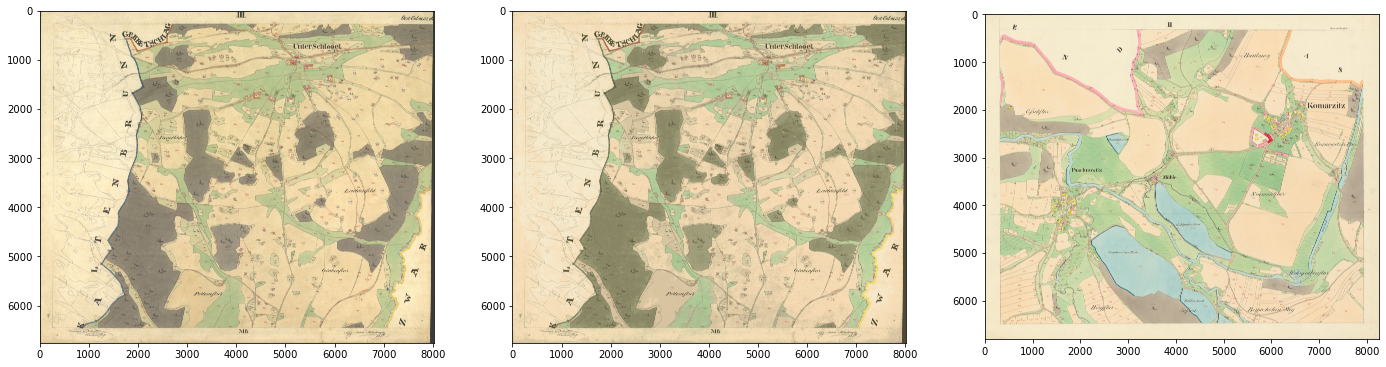

In [32]:
tgt_recolor = palette_a.recolor(tgt)
tgt_recolor_img = Image.fromarray(tgt_recolor)
# display(tgt_recolor_img.resize(maxsize, Image.LANCZOS))

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(24,16)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(tgt_img)
axarr[1].imshow(tgt_recolor_img)
axarr[2].imshow(src_img)
plt.show()

- - - 
## Unique redukovaná paleta:
K-Mean algorytmus pouze pro 'k_colors'  barev  na těžištích barev
výrazně kratší procesní čas

Wall time: 1min 52s


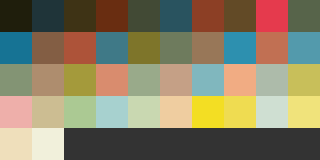

In [63]:
%%time
k_colors = 42
palette_u = UniqueKMeansReducedPalette(k_colors)
palette_u.fit(src)
visualize_palette(np.round(palette_u.kmeans.cluster_centers_).astype(np.uint8), scale=32)

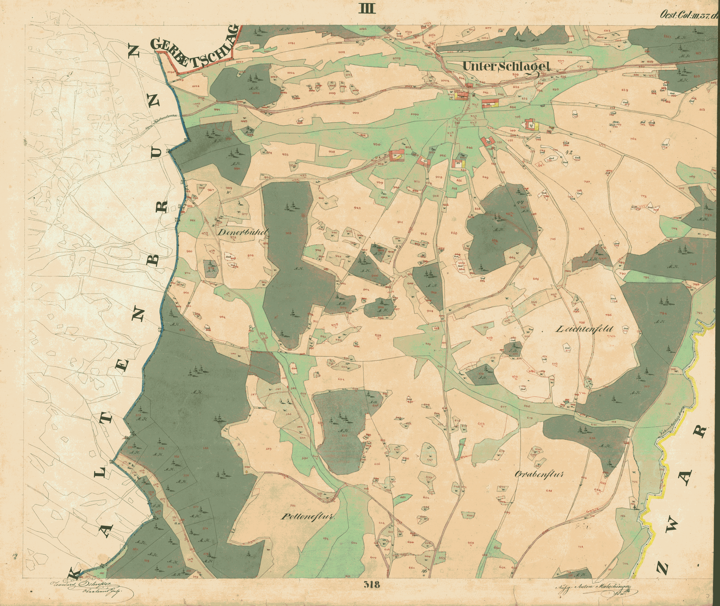

1

Wall time: 11.3 s


In [64]:
%%time
tgt_recolor = palette_u.recolor(tgt)
tgt_recolor_img = Image.fromarray(tgt_recolor)
display(img_resize(tgt_recolor_img), Image.LANCZOS)

Wall time: 1min 29s


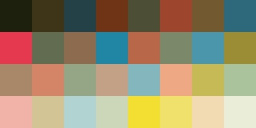

In [61]:
%%time
k_colors = 32
palette_u32 = UniqueKMeansReducedPalette(k_colors)
palette_u32.fit(src)
visualize_palette(np.round(palette_u32.kmeans.cluster_centers_).astype(np.uint8), scale=32)

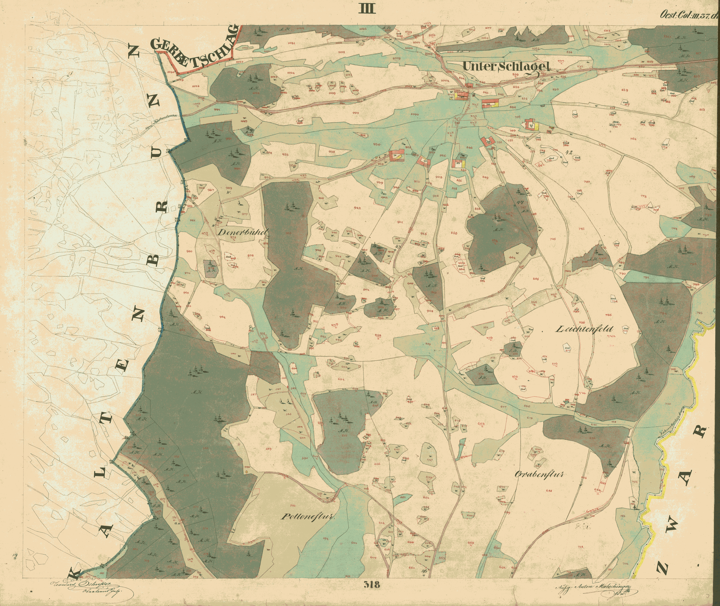

1

Wall time: 10.2 s


In [62]:
%%time
tgt_recolor32 = palette_u32.recolor(tgt)
tgt_recolor32_img = Image.fromarray(tgt_recolor32)
display(img_resize(tgt_recolor32_img), Image.LANCZOS)

Wall time: 1min 24s


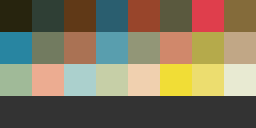

In [58]:
%%time
k_colors = 24
palette_u24 = UniqueKMeansReducedPalette(k_colors)
palette_u24.fit(src)
visualize_palette(np.round(palette_u24.kmeans.cluster_centers_).astype(np.uint8), scale=32)

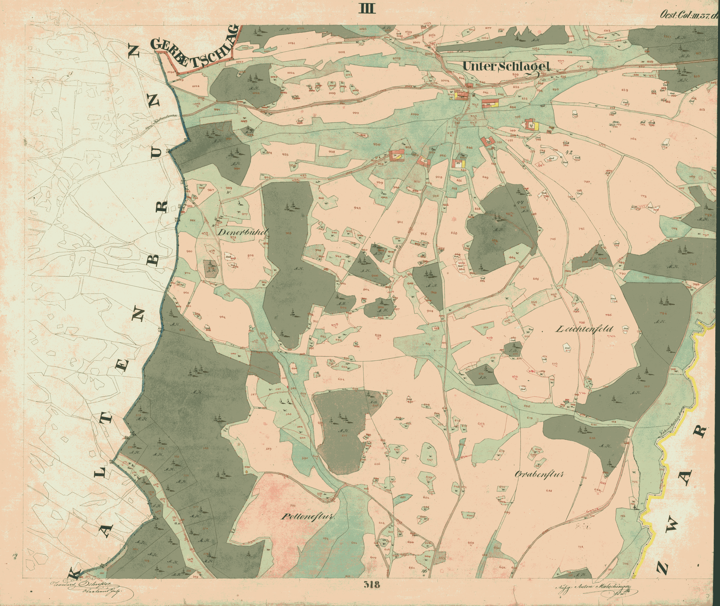

1

Wall time: 9.93 s


In [60]:
%%time
tgt_recolor24 = palette_u24.recolor(tgt)
tgt_recolor24_img = Image.fromarray(tgt_recolor24)
display(img_resize(tgt_recolor24_img), Image.LANCZOS)

Wall time: 1min 11s


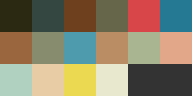

In [56]:
%%time
k_colors = 16
palette_u16 = UniqueKMeansReducedPalette(k_colors)
palette_u16.fit(src)
visualize_palette(np.round(palette_u16.kmeans.cluster_centers_).astype(np.uint8), scale=32)

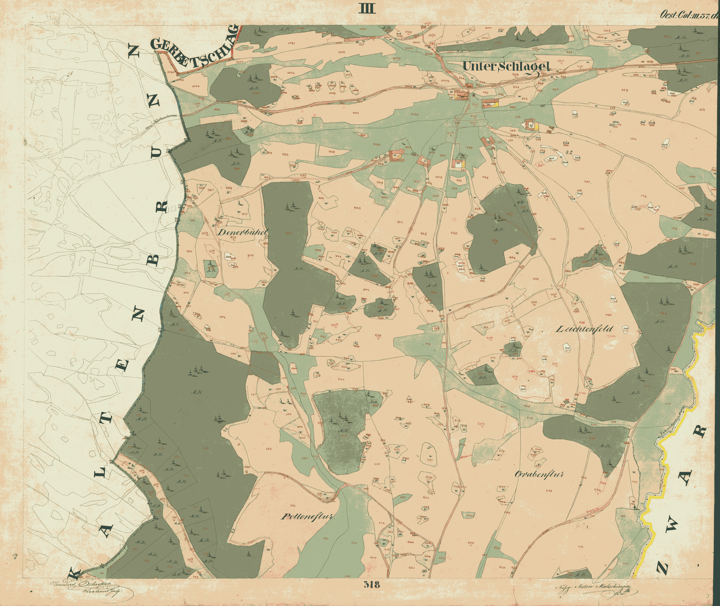

1

Wall time: 9.73 s


In [57]:
%%time
tgt_recolor16 = palette_u16.recolor(tgt)
tgt_recolor16_img = Image.fromarray(tgt_recolor16)
display(img_resize(tgt_recolor16_img), Image.LANCZOS)

Wall time: 1min 3s


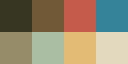

In [39]:
%%time
k_colors = 8
palette_u8 = UniqueKMeansReducedPalette(k_colors)
palette_u8.fit(src)
visualize_palette(np.round(palette_u8.kmeans.cluster_centers_).astype(np.uint8), scale=32)

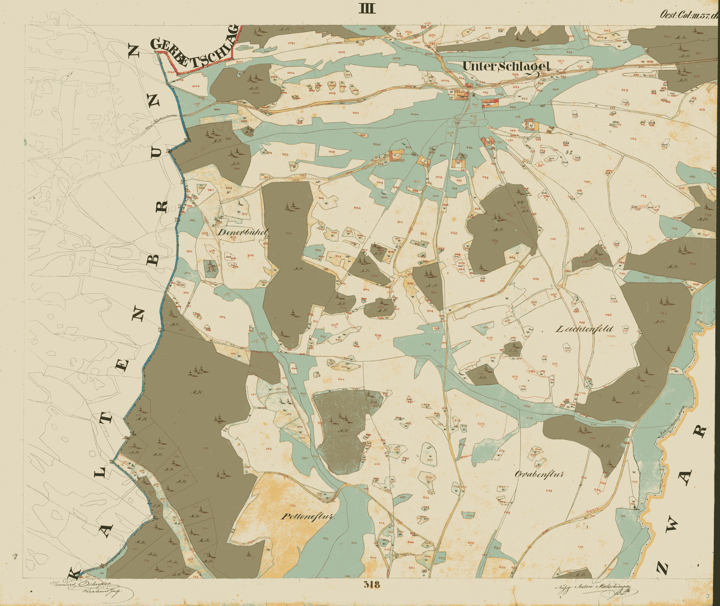

1

In [52]:
tgt_recolor8 = palette_u8.recolor(tgt)
tgt_recolor8_img = Image.fromarray(tgt_recolor8)
display(img_resize(tgt_recolor8_img), Image.LANCZOS)

Wall time: 1min 2s


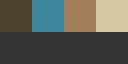

In [53]:
%%time
k_colors = 4
palette_u4 = UniqueKMeansReducedPalette(k_colors)
palette_u4.fit(src)
visualize_palette(np.round(palette_u4.kmeans.cluster_centers_).astype(np.uint8), scale=32)

- - - 
## Podstrčení vlastní palety barev

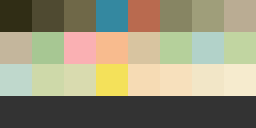

In [116]:
# Puvodi K-MEAN full paleta 24 barev
visualize_palette(np.round(palette_a.kmeans.cluster_centers_).astype(np.uint8), scale=32)

In [135]:
my_palette_of_4 = np.array(
    [[186, 169, 153],
    [166, 199, 150],
    [56, 134, 163],
    [ 247, 234, 206]]).astype(np.float64)

print(my_palette_of_4)
print(my_palette_of_4.dtype)

[[186. 169. 153.]
 [166. 199. 150.]
 [ 56. 134. 163.]
 [247. 234. 206.]]
float64


In [136]:
palette_u4.kmeans.cluster_centers_ = my_palette_of_4

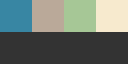

In [137]:
visualize_palette(np.round(my_palette_of_4).astype(np.uint8), scale=32)

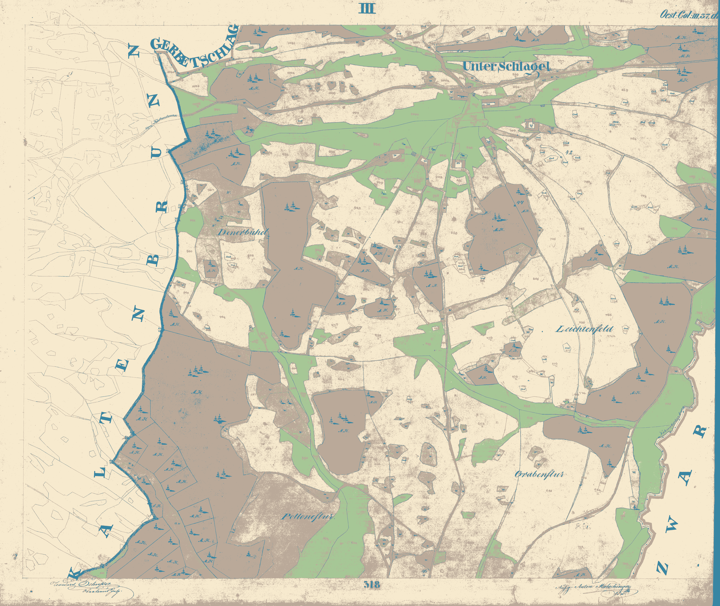

1

Wall time: 6.37 s


In [138]:
%%time
tgt_recolor4 = palette_u4.recolor(tgt)
tgt_recolor4_img = Image.fromarray(tgt_recolor4)
display(img_resize(tgt_recolor4_img), Image.LANCZOS)

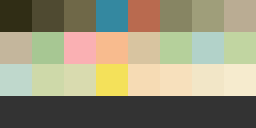

In [143]:
# 24colors Full paleta
visualize_palette(np.round(palette_a.kmeans.cluster_centers_).astype(np.uint8), scale=32)

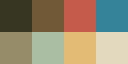

In [142]:
# 8 colors Unique reduced
# k_colors = 8
# palette_u8 = UniqueKMeansReducedPalette(k_colors)
# palette_u8.fit(src)
visualize_palette(np.round(palette_u8.kmeans.cluster_centers_).astype(np.uint8), scale=32)

In [141]:
np.round(palette_u8.kmeans.cluster_centers_).astype(np.uint8)

array([[151, 140, 104],
       [ 53,  53,  35],
       [227, 187, 116],
       [113,  88,  55],
       [227, 217, 190],
       [169, 189, 163],
       [ 52, 131, 154],
       [195,  91,  74]], dtype=uint8)

In [183]:
my_palette_of_8 = np.array(
    [[245, 224, 187], # polnosti - piskova
    [187, 170, 154],  # lesy - hneda
    [0, 0, 0], # cerna
    [163, 196, 147], # louky - tmavsi zelena
    [204, 220, 171], # louky - svetlejsi zelena
    [179, 207, 204], # voda - sedomodra
    [235, 62, 87], # budovy - cervena
    [ 255, 255, 0]] # lesy - tmavohneda
    ).astype(np.float64)

#     [ 56, 130, 155]] # hranice - tyrkysova
#     [ 106, 98, 90]] # lesy - tmavohneda

print(my_palette_of_8)
print(my_palette_of_8.dtype)

[[245. 224. 187.]
 [187. 170. 154.]
 [  0.   0.   0.]
 [163. 196. 147.]
 [204. 220. 171.]
 [179. 207. 204.]
 [235.  62.  87.]
 [255. 255.   0.]]
float64


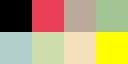

In [184]:
visualize_palette(np.round(my_palette_of_8).astype(np.uint8), scale=32)

In [185]:
palette_u8.kmeans.cluster_centers_ = my_palette_of_8

<Figure size 432x288 with 0 Axes>

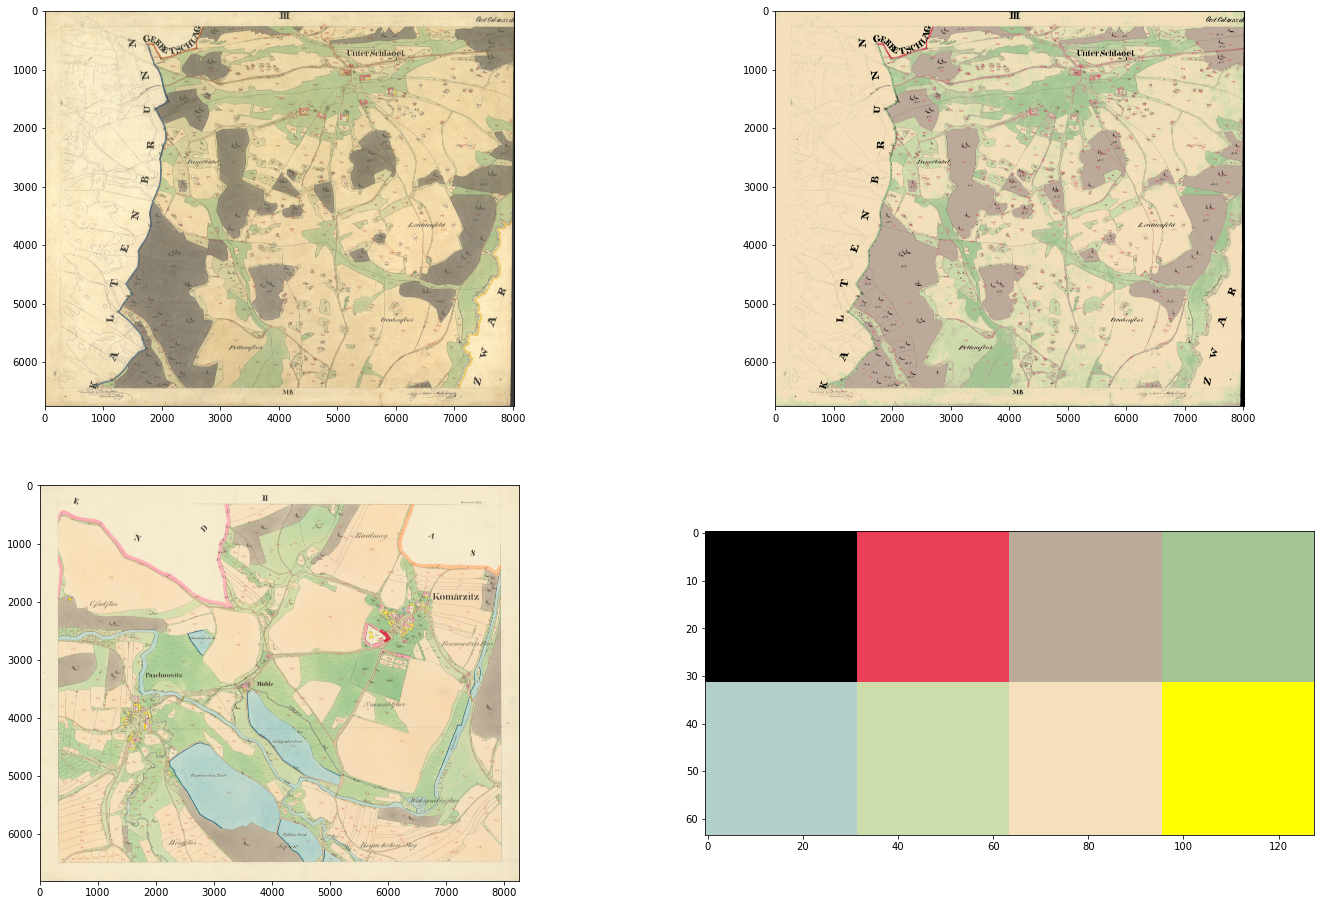

In [186]:
tgt_recolor8 = palette_u8.recolor(tgt)
tgt_recolor8_img = Image.fromarray(tgt_recolor8)
# display(img_resize(tgt_recolor8_img, 1024), Image.LANCZOS)

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2, figsize=(24,16)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0, 0].imshow(tgt_img)
axarr[0, 1].imshow(tgt_recolor8_img)
axarr[1, 0].imshow(src_img)
axarr[1, 1].imshow(visualize_palette(np.round(my_palette_of_8).astype(np.uint8), scale=32))
plt.show()